# Binned Jeans analysis tutorial

In this example, we will use JeansGNN to perform a binned Jeans analysis to recover
the dark matter density profile of an example dwarf galaxy.

This implementation is based on the following paper:
- [1] Chang & Necib (2020) https://arxiv.org/abs/2009.00613

In [21]:
%load_ext autoreload
%autoreload 2

import bilby
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch_geometric
import yaml

import jeans_gnn as jgnn

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read an example galaxy 
As a first step, we read the 2D position and line-of-sight velocity of the stars in the example galaxy. 

Note that unlike the GNN-based inference in `jgnn.gnn`, the Jeans analysis is more computationally intensive, so we can only fit one galaxy at a time.

In [22]:
# Read the example datasets and pick the first galaxy (though any galaxy will work)
dataset_path = 'data/example_data.hdf5'
node_features, graph_features, headers = jgnn.utils.dataset.read_graph_dataset(
    dataset_path, features_list=['pos', 'vel', 'vel_error', 'labels'])

# Pick the first galaxy
pos = node_features['pos'][1]
vel = node_features['vel'][1]
vel_error = node_features['vel_error'][1]
data = {'pos': pos, 'vel': vel, 'vel_error': vel_error}
truth_parameters = {
    k: v for k, v in zip(headers['labels_order'], graph_features['labels'][1])}

# Print out the truth parameters and the node features of the first 10 stars
print('True parameters:')
for k, v in truth_parameters.items():
    print(f'{k}: {v}')
print("Node features:")
print("- pos: {}".format(node_features['pos'][0][:10]))
print("- vel: {}".format(node_features['vel'][0][:10]))

True parameters:
dm_gamma: 1.0077498109274279
dm_log_r_dm: -0.633612420092535
dm_log_rho_0: 6.866133214871631
stellar_log_r_star: -1.2141546817176612
df_beta_0: 0.12881816386775002
df_log_r_a: -0.9183926283597472
Node features:
- pos: [[ 0.13504457  0.05950324]
 [-0.03729184 -0.151646  ]
 [-0.11927976 -0.11157647]
 [-0.03330625  0.06756137]
 [-0.00840738  0.03095477]
 [ 0.07772832 -0.04542598]
 [-0.06865919 -0.04856362]
 [ 0.02304553  0.0593613 ]
 [ 0.00202816  0.00174576]
 [ 0.10052064  0.04847484]]
- vel: [ 0.29824803 -0.04545442  0.21565156 -0.46745416 -0.20959343 -0.14228842
  0.66527882  0.53476856  0.24639451 -0.36439535]


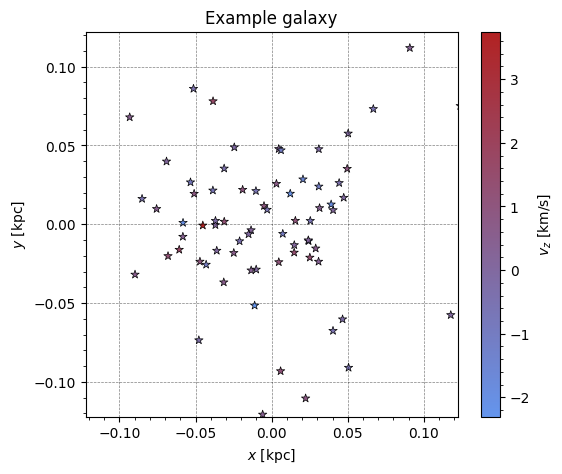

In [23]:
# Plot the example galaxy
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# some plotting parameters
s = 40
marker = '*'
# create a colormap by adding gradients between colors
color1 = 'cornflowerblue'
color2 = 'firebrick'
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'mycmap', [color1, color2])
box_size = 2 * 10**truth_parameters['stellar_log_r_star']

# create a log scale for the colorbar
norm = mpl.colors.Normalize(vmin=vel.min(), vmax=vel.max())

# plot the stars
sc = ax.scatter(
    pos[:, 0], pos[:, 1], c=vel, s=s, marker=marker, cmap=cmap,
    norm=norm, edgecolors='k', linewidths=0.5)
ax.set_xlabel(r'$x$ [kpc]')
ax.set_ylabel(r'$y$ [kpc]')
ax.set_title('Example galaxy')
ax.set_xlim(-box_size, box_size)
ax.set_ylim(-box_size, box_size)

# minor ticks and major grid
ax.minorticks_on()
ax.grid(which='major', linestyle='--', alpha=0.5, linewidth='0.5', color='black')

# colorbar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label(r'$v_z$ [km/s]')
cbar.ax.minorticks_on()

plt.show()

## Example 1: Fit the Plummer profile to the light profile

In this example, we will fit the 2D Plummer profile to the light profile of the galaxy. This is a good first step to check if the JeansGNN is working properly.

The 2D Plummer profile has the following form:
$$
I(R) = \frac{L}{\pi a^2} \left[ 1 + \left(\frac{R}{a}\right)^2 \right]^{-2} 
$$
where $L$ is the total luminosity of the galaxy, $a$ is the Plummer scale length, and $R$ is the 2D radius from the center of the galaxy.

In order to fit the Plummer profile with JeansGNN, we will use `jgnn.jeans.binned_lp_model.BinnedLPModel`. We need to specify the following:
- `density`: The light profile of the galaxy, which is a `jgnn.jeans.density_profile.DensityProfile` object. In this example, we will use `jgnn.jeans.density_profile.PlummerProfile` to represent the Plummer profile.
- `data`: The dictionary containing the position of stars. The required key for this example is only `pos`, which is the position of stars. Light profile fit does not require velocity information.
- `priors`: A dictionary containing all the prior distributions in `bilby.core.prior` format.


In [24]:
# Define the bilby priors
priors = bilby.core.prior.PriorDict()
priors["L"] = bilby.core.prior.LogUniform(1e-2, 1e5, "L")
priors["r_star"] = bilby.core.prior.LogUniform(1e-3, 1e3, "r_star")

# Define the light profile model
lp_model = jgnn.jeans.binned_lp_model.BinnedLPModel(
    jgnn.jeans.density_profiles.Plummer, data, priors)

We will run the fit using `bilby` and `dynesty`

In [25]:
# run sampler
lp_model.run_sampler(
    sampler="dynesty", npoints=1000, sample='auto', npool=1, dlogz=0.1,
    label="lp", outdir='example_binned_jeans', resume=False
)

17:23 bilby INFO    : Running for label 'lp', output will be saved to 'example_binned_jeans'


To examine the posteriors, we first compare the 1D marginalized posteriors of the parameters with the truth values. 

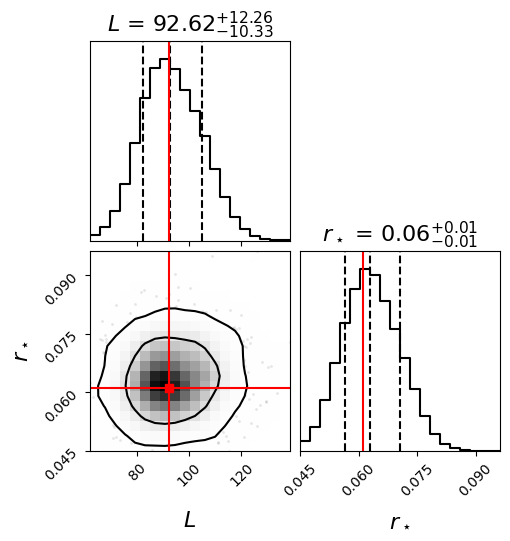

In [ ]:
# get posterior samples
samples = lp_model.result.posterior[['L', 'r_star']].to_numpy()

# set truth values, note that L is roughly equal to the number of stars
truths = (len(pos),  10**truth_parameters['stellar_log_r_star'])

plot_args = dict(
    truth_color='red', truth_alpha=0.5, truth_kwargs={'linewidth': 2},
    label_kwargs={'fontsize': 16}, title_kwargs={'fontsize': 16},
    show_titles=True, labels=[r'$L$', r'$r_\star$'],
    levels=[0.68, 0.95], smooth=1.0, smooth1d=1.0, quantiles=[0.16, 0.5, 0.84],
)

fig = corner.corner(
    samples, truths=truths, **plot_args
)

The posteriors look consistent with the truth parameters!
<!-- but a bit noisy. This is because we only use `nlive=100` walkers in `dynesty`. We can increase the number of walkers to improve the convergence at a cost of longer computation time. -->

In the next test, we plot the truth Plummer profile (both analytical and binned) and compare it with the fitted Plummer profile.

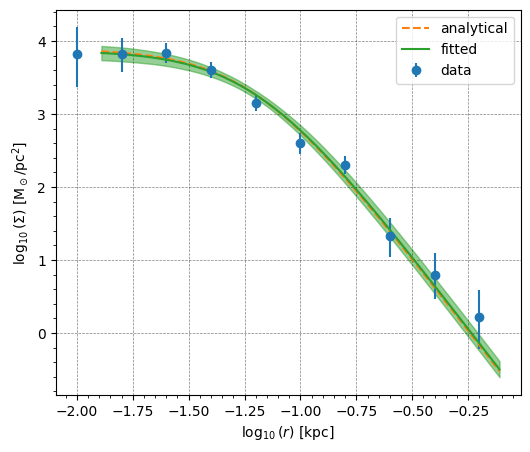

In [7]:
# fitted Plummer model
L_fit = lp_model.result.posterior['L'].to_numpy()
r_star_fit = lp_model.result.posterior['r_star'].to_numpy()
plummer_fit = jgnn.jeans.density_profiles.Plummer(
    L_fit, r_star_fit, projected=True)

# analytical Plummer model
plummer_ana = jgnn.jeans.density_profiles.Plummer(
    L=truths[0], r_star=truths[1], projected=True)

# binned the data
radius = np.linalg.norm(pos, axis=1)
binned_data = jgnn.jeans.utils.calc_Sigma(radius, return_bounds=True)
Sigma, Sigma_lo, Sigma_hi, logR_bins_lo, logR_bins_hi = binned_data

# Plot the light profile logR vs logL
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# plot the binned data as error bars
logR_bins_ce = 0.5 * (logR_bins_lo + logR_bins_hi)
yerr = (np.log10(Sigma) - np.log10(Sigma_lo), np.log10(Sigma_hi) - np.log10(Sigma))
ax.errorbar(logR_bins_ce, np.log10(Sigma), yerr=yerr, fmt='o', label='data')

# plot the fitted and analytical Plummer models
# get min and max radius for plotting
log_r_min = logR_bins_lo.min() * 0.9
log_r_max = logR_bins_hi.max() * 1.1
r = np.logspace(log_r_min, log_r_max, 100)

# plot the analytical Plummer model
ax.plot(np.log10(r), np.log10(plummer_ana(r)), ls='--', label='analytical')

# plot the fitted Plummer model median and 1 sigma range
plummer_fit_q = np.nanpercentile(plummer_fit(r), [16, 50, 84], axis=1)
ax.plot(np.log10(r), np.log10(plummer_fit_q[1]), ls='-', color='C2', label='fitted')
ax.fill_between(
    np.log10(r), np.log10(plummer_fit_q[0]), np.log10(plummer_fit_q[2]),
    alpha=0.5, color='C2')

# set axis labels
ax.set_xlabel(r'$\log_{10}(r)$ [kpc]')
ax.set_ylabel(r'$\log_{10}(\Sigma)$ [M$_\odot$/pc$^2$]')

# minor ticks and major grid
ax.minorticks_on()
ax.grid(which='major', linestyle='--', alpha=0.5, linewidth='0.5', color='black')

# legend
ax.legend()

plt.show()

Again, we can see that the fitted Plummer profile is consistent with the truth Plummer profile!

## Example 2: Fit the generalized NFW profile using the Jeans equation

In this example, we will fit the generalized NFW profile to the dark matter density profile of the galaxy. This is a good second step to check if the JeansGNN is working properly.

The generalized NFW profile has the following form:
$$
\rho(r) = \rho_0 \left(\frac{r}{r_\mathrm{dm}}\right)^{-\gamma} \left( 1 + \frac{r}{r_\mathrm{dm}} \right)^{-3+\gamma}
$$
where $\rho_0$ is the density normalization, $r_\mathrm{dm}$ is the scale radius, and $\gamma$ is inner slope.

Here, we will use `jgnn.jeans.binned_jeans_model.BinnedJeansModel` to fit the generalized NFW profile. We need to specify the following:
- `dm_profile`: The dark matter density profile of the galaxy, which is a `jgnn.jeans.density_profile.DensityProfile` object. In this example, we will use `jgnn.jeans.density_profile.GeneralizedNFW` to represent the generalized NFW profile.
- `lp_profile`: The light profile of the galaxy, which is a `jgnn.jeans.density_profile.DensityProfile` object. In this example, we will use `jgnn.jeans.density_profile.PlummerProfile` to represent the light profile as a Plummer profile.
- `dist_function`: The distribution function of stars that connects the light profile and the dark matter density profile. In this example, we will use `jgnn.jeans.dist_functions.OsipkovMerritt` to represent the distribution function.
- `data`: The dictionary containing the kinematics of stars. The required keys for Jeans fit are `pos`, `vel`, and `vel_error`, which are for the position, velocity, and velocity error of the stars, respectively.
- `priors`: A dictionary containing all the prior distributions in `bilby.core.prior` format.
  - For simplicity, we will set `L` and `r_star` to the best fit values from the light profile fit. In practice, we should also fit for these parameters.
  - For simplicity, the parameters of the Osipkov-Merritt distribution function are fixed to their truth values. These are `beta_0` and `r_a`, which are the normalization and scale radius of the velocity anisotropy, respectively. In practice, we should also fit for these parameters.

In addition, we set a few additional parameters:
- `dr`: The radial bin size in kpc.
- `fit_v_mean`: Whether to fit for the mean velocity of the stars. If `True`, the mean velocity will be treated as a free parameter. If `False`, the mean velocity will be fixed to the mean of the input velocity.

In [11]:
# Set priors for the Jeans model
priors = bilby.core.prior.PriorDict()
# set gNFW priors
priors["r_dm"] = bilby.core.prior.LogUniform(0.1, 10, "r_dm")
priors["gamma"] = bilby.core.prior.Uniform(-1, 2, "gamma")
priors["rho_0"] = bilby.core.prior.LogUniform(1e5, 1e8, "rho_0")
# set Plummer priors to be fixed at the fitted values
priors["L"] = bilby.core.prior.DeltaFunction(lp_model.get_median('L'), "L")
priors["r_star"] = bilby.core.prior.DeltaFunction(lp_model.get_median('r_star'), "r_star")
# set the prior on the velocity anisotropys to be fixed at the truth
priors['r_a'] = bilby.core.prior.DeltaFunction(10**truth_parameters['df_log_r_a'], 'r_a')
priors['beta_0'] = bilby.core.prior.DeltaFunction(truth_parameters['df_beta_0'], 'beta_0')

priors['v_mean'] = bilby.core.prior.Uniform(-200, 200, 'v_mean')

dm_model = jgnn.jeans.binned_jeans_model.BinnedJeansModel(
    dm_profile=jgnn.jeans.density_profiles.GeneralizedNFW,
    lp_profile=jgnn.jeans.density_profiles.Plummer,
    dist_function=jgnn.jeans.dist_functions.OsipkovMerritt,
    data=data, priors=priors, fit_v_mean=True, dr=0.01
)

In [12]:
# Run dynesty, increasing the number of processors to 8 to speed up the run
dm_model.run_sampler(
    sampler="dynesty", npoints=1000, sample='auto', npool=8, dlogz=0.1,
    label="dm", outdir='example_binned_jeans', resume=False
)

14:35 bilby INFO    : Running for label 'dm', output will be saved to 'example_binned_jeans'
14:35 bilby INFO    : Analysis priors:
14:35 bilby INFO    : r_dm=LogUniform(minimum=0.1, maximum=10, name='r_dm', latex_label='r_dm', unit=None, boundary=None)
14:35 bilby INFO    : gamma=Uniform(minimum=-1, maximum=2, name='gamma', latex_label='gamma', unit=None, boundary=None)
14:35 bilby INFO    : rho_0=LogUniform(minimum=100000.0, maximum=100000000.0, name='rho_0', latex_label='rho_0', unit=None, boundary=None)
14:35 bilby INFO    : v_mean=Uniform(minimum=-200, maximum=200, name='v_mean', latex_label='v_mean', unit=None, boundary=None)
14:35 bilby INFO    : L=92.80310147670447
14:35 bilby INFO    : r_star=0.0631488882542006
14:35 bilby INFO    : r_a=0.12067223921189237
14:35 bilby INFO    : beta_0=0.12881816386775002
14:35 bilby INFO    : Analysis likelihood class: <class 'jeans_gnn.jeans.binned_jeans_model.BinnedJeansModel'>
14:35 bilby INFO    : Analysis likelihood noise evidence: nan
14

15056it [01:30, 235.31it/s, bound:71 nc:  1 ncall:7.8e+04 eff:19.5% logz=-134.91+/-0.10 dlogz:0.089>0.1]     

14:37 bilby INFO    : Written checkpoint file example_binned_jeans/dm_resume.pickle
14:37 bilby INFO    : Starting to close worker pool.
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f336c5ba4c0>
  self.pid = os.fork()
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f336c5ba4c0>
  self.pid = os.fork()
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f336c5ba4c0>
  self.pid = os.fork()
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f336c5ba4c0>
  self.pid = os.fork()
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/multiprocessing/popen_fork.py:70: Resou

15056it [01:41, 148.89it/s, bound:71 nc:  1 ncall:7.9e+04 eff:20.6% logz=-134.85+/-0.10 dlogz:0.000>0.1]

14:37 bilby INFO    : Rejection sampling nested samples to obtain 3178 posterior samples
14:37 bilby INFO    : Sampling time: 0:01:41.082849


14:37 bilby INFO    : Summary of results:
nsamples: 3178
ln_noise_evidence:    nan
ln_evidence: -134.851 +/-  0.131
ln_bayes_factor:    nan +/-  0.131



Because we don't have access to the DM particles, we will only plot the corner plot of the fitted parameters and compare it with the truth values.

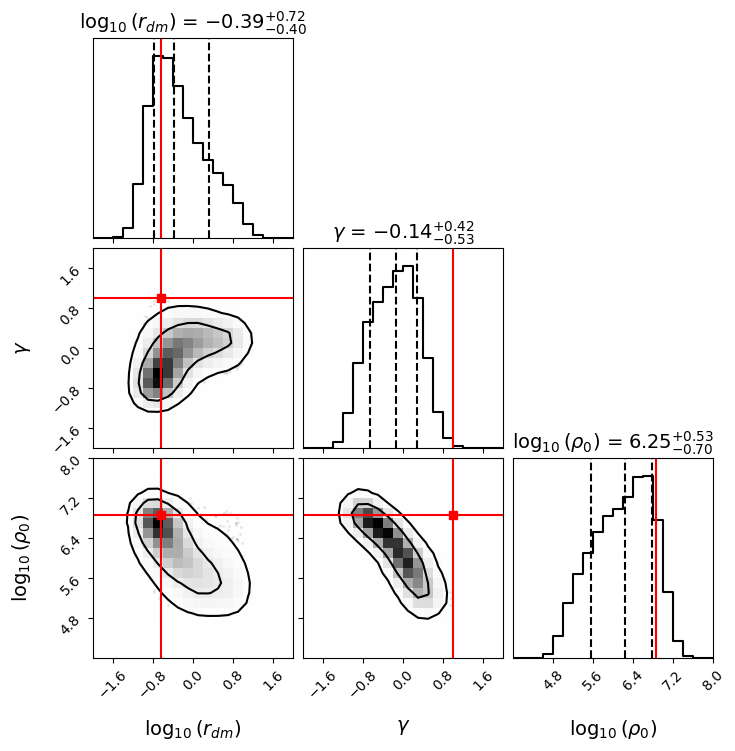

In [13]:
# get posterior samples
samples = dm_model.result.posterior[ ['r_dm', 'gamma', 'rho_0']].to_numpy()
# convert r_dm and rho_0 to log values
samples[:, 0] = np.log10(samples[:, 0])
samples[:, 2] = np.log10(samples[:, 2])

# set truth values, note that L is roughly equal to the number of stars
truths = (
    truth_parameters['dm_log_r_dm'], truth_parameters['dm_gamma'], 
    truth_parameters['dm_log_rho_0'],
)
range = (
    (-2, 2), (-2, 2), (4, 8)
)

plot_args = dict(
    truth_color='red', truth_alpha=0.5, truth_kwargs={'linewidth': 2},
    label_kwargs={'fontsize': 14}, title_kwargs={'fontsize': 14},
    show_titles=True, labels=[r'$\log_{10}(r_{dm})$', r'$\gamma$', r'$\log_{10}(\rho_0)$'],
    levels=[0.68, 0.95], smooth=1.0, smooth1d=1.0, quantiles=[0.16, 0.5, 0.84],
    range=range
)

fig = corner.corner(
    samples, truths=truths, **plot_args
)

## Example 3: Combining everything using JeansGNN wrapper

In this example, we will show how to use JeansGNN InferenceModel to apply the joint DM and light profile fit to a galaxy.
We will use `jgnn.im.jeans_im.JeansInferenceModel` to fit the generalized NFW profile to the dark matter density profile of the galaxy.

An example config file with parameters for the JeansGNN wrapper is provided in `config/jeans_im.yaml`. We will use this config file to run the fit.

In [17]:
# Read config file and print out all information
with open('example_binned_jeans.yaml', 'r') as f:
    config = yaml.safe_load(f)

# print in yaml format
print(yaml.dump(config, sort_keys=False))

method: Jeans
model:
  lp_prior_type: best_median
  jeans_fit:
    fit_v_mean: false
    r_min_factor: 0.5,
    r_max_factor: 2
    dr: 0.1
priors:
  r_dm:
    type: LogUniform
    minimum: 0.1
    maximum: 10
  gamma:
    type: Uniform
    minimum: -1
    maximum: 2
  rho_0:
    type: LogUniform
    minimum: 100000.0
    maximum: 100000000.0
  L:
    type: LogUniform
    minimum: 0.01
    maximum: 100000.0
  r_star:
    type: LogUniform
    minimum: 0.001
    maximum: 1000.0
  r_a:
    type: DeltaFunction
    peak: 0.12067223921189237
  beta_0:
    type: DeltaFunction
    peak: 0.12881816386775002



The prior distribution is defined in `config/jeans_im.yaml`. The prior is parsed automatically by `JeansInferenceModel`.

The JeansInference Model will perform 2 fits:
- A light profile fit using `jgnn.jeans.binned_lp_model.BinnedLPModel`. The priors of the light profile parameters are determined by `config[priors]`.
- A joint DM and light profile fit using `jgnn.jeans.binned_jeans_model.BinnedJeansModel`. The priors of the light profile parameters are determined by the light profile fit using the config `lp_prior_type` option in `config[model]`.

In [20]:
inference_model.parameters

{'dm': ['r_dm', 'gamma', 'rho_0'],
 'lp': ['L', 'r_star'],
 'df': ['beta_0', 'r_a'],
 'other': []}

In [18]:
inference_model = jgnn.im.jeans_im.JeansInferenceModel(
    run_name='example_binned_jeans',
    priors=config['priors'],
    model_params=config['model'],
)

# Note that we can also use the config file directly
# The following lines are equivalent to the above
# inference_model = jgnn.im.jeans_im.JeansInferenceModel(
    # run_name='example_binned_jeans',
    # config_file='example_binned_jeans.yaml',
# )

In [19]:
# Call dynesty and return both  the DM and LP models
dm_model, lp_model = inference_model.sample(
    data, sampler='dynesty', sampler_args={
        'npoints': 1000, 'sample': 'auto', 'npool': 8, 'dlogz': 0.1}, 
        return_lp_model=True
)

17:21 bilby INFO    : Running for label 'lp_fit', output will be saved to 'example_binned_jeans/data'
17:21 bilby INFO    : Analysis priors:
17:21 bilby INFO    : L=LogUniform(minimum=0.01, maximum=100000.0, name='L', latex_label='L', unit=None, boundary=None)
17:21 bilby INFO    : r_star=LogUniform(minimum=0.001, maximum=1000.0, name='r_star', latex_label='r_star', unit=None, boundary=None)
17:21 bilby INFO    : Analysis likelihood class: <class 'jeans_gnn.jeans.binned_lp_model.BinnedLPModel'>
17:21 bilby INFO    : Analysis likelihood noise evidence: nan
17:21 bilby INFO    : Single likelihood evaluation took 9.293e-05 s
17:21 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 1000, 'bound': 'live', 'sample': 'auto', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 8, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': 

10336it [00:42, 566.42it/s, bound:16 nc:  1 ncall:4.6e+04 eff:22.3% logz=-10.98+/-0.08 dlogz:0.107>0.1] 

17:22 bilby INFO    : Written checkpoint file example_binned_jeans/data/lp_fit_resume.pickle
17:22 bilby INFO    : Starting to close worker pool.
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7efd641f1580>
  self.pid = os.fork()
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7efd641f1580>
  self.pid = os.fork()
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7efd641f1580>
  self.pid = os.fork()
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7efd641f1580>
  self.pid = os.fork()
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/multiprocessing/popen_fork.py:

10398it [00:50, 207.85it/s, bound:17 nc:  1 ncall:4.8e+04 eff:24.5% logz=-10.88+/-0.08 dlogz:0.000>0.1]

17:22 bilby INFO    : Rejection sampling nested samples to obtain 2732 posterior samples
17:22 bilby INFO    : Sampling time: 0:00:49.983729


17:22 bilby INFO    : Summary of results:
nsamples: 2732
ln_noise_evidence:    nan
ln_evidence: -10.881 +/-  0.107
ln_bayes_factor:    nan +/-  0.107

17:22 bilby INFO    : Running for label 'dm_fit', output will be saved to 'example_binned_jeans/data'
17:22 bilby WARNING : Parameter v_mean has no default prior and is set to None, this will not be sampled and may cause an error.
17:22 bilby INFO    : Analysis priors:
17:22 bilby INFO    : r_dm=LogUniform(minimum=0.1, maximum=10, name='r_dm', latex_label='r_dm', unit=None, boundary=None)
17:22 bilby INFO    : gamma=Uniform(minimum=-1, maximum=2, name='gamma', latex_label='gamma', unit=None, boundary=None)
17:22 bilby INFO    : rho_0=LogUniform(minimum=100000.0, maximum=100000000.0, name='rho_0', latex_label='rho_0', unit=None, boundary=None)
17:22 bilby INFO    : L=92.85707003109601
17:22 bilby INFO    : r_star=0.06296774976031877
17:22 bilby INFO    : r_a=0.12067223921189237
17:22 bilby INFO    : beta_0=0.12881816386775002
17:22 bilby 

TypeError: Likelihood evaluation failed with message: 
'unsupported operand type(s) for -: 'float' and 'NoneType''
Have you specified all the parameters:
{'r_dm': 0.2381919887213765, 'gamma': 0.6293382381905888, 'rho_0': 580749.4440414485, 'L': 92.85707003109601, 'r_star': 0.06296774976031877, 'beta_0': 0.12881816386775002, 'r_a': 0.12067223921189237, 'v_mean': None}

Similarly, we want see if the fitted parameters are consistent with the truth values and with the posteriors in Example 1 & 2 

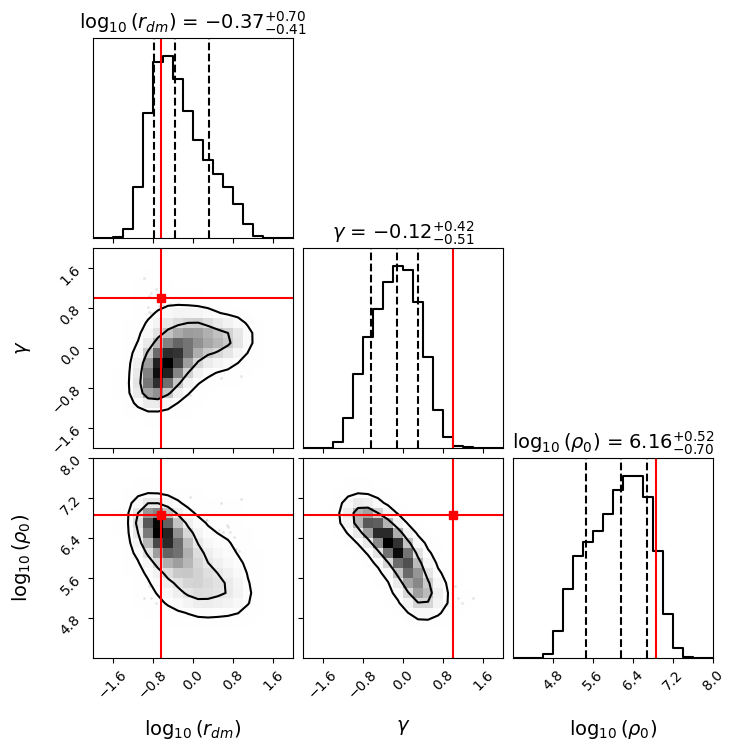

In [107]:
# get posterior samples
samples = dm_model.result.posterior[ ['r_dm', 'gamma', 'rho_0']].to_numpy()
# convert r_dm and rho_0 to log values
samples[:, 0] = np.log10(samples[:, 0])
samples[:, 2] = np.log10(samples[:, 2])

# set truth values, note that L is roughly equal to the number of stars
truths = (
    truth_parameters['dm_log_r_dm'], truth_parameters['dm_gamma'], 
    truth_parameters['dm_log_rho_0'],
)
range = (
    (-2, 2), (-2, 2), (4, 8)
)

plot_args = dict(
    truth_color='red', truth_alpha=0.5, truth_kwargs={'linewidth': 2},
    label_kwargs={'fontsize': 14}, title_kwargs={'fontsize': 14},
    show_titles=True, labels=[r'$\log_{10}(r_{dm})$', r'$\gamma$', r'$\log_{10}(\rho_0)$'],
    levels=[0.68, 0.95], smooth=1.0, smooth1d=1.0, quantiles=[0.16, 0.5, 0.84],
    range=range
)

fig = corner.corner(
    samples, truths=truths, **plot_args
)